In [11]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce GTX 1080


In [13]:
DATA_DIRECTORY = "../../dataset/foldered/car_data/car_data/"

In [14]:
train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_ds = torchvision.datasets.ImageFolder(root=DATA_DIRECTORY+"train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(train_ds, batch_size = 32, shuffle=True, num_workers = 2)


In [15]:
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_ds = torchvision.datasets.ImageFolder(root=DATA_DIRECTORY+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(test_ds, batch_size = 32, shuffle=False, num_workers = 2)

In [16]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx, len(classes)
classes, c_to_idx, CLASS_NUM = find_classes(DATA_DIRECTORY+"train")

In [17]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [18]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [19]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, CLASS_NUM)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [20]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

Epoch 1, duration: 116 s, loss: 3.9713, acc: 15.5025
Accuracy of the network on the test images: 35 %
Epoch 2, duration: 116 s, loss: 1.6633, acc: 56.4093
Accuracy of the network on the test images: 55 %
Epoch 3, duration: 121 s, loss: 0.8865, acc: 76.2132
Accuracy of the network on the test images: 62 %
Epoch 4, duration: 119 s, loss: 0.5327, acc: 85.6373
Accuracy of the network on the test images: 75 %
Epoch 5, duration: 114 s, loss: 0.3602, acc: 90.0368
Accuracy of the network on the test images: 80 %
Epoch 6, duration: 117 s, loss: 0.2633, acc: 92.6838
Accuracy of the network on the test images: 80 %
Epoch 7, duration: 121 s, loss: 0.1917, acc: 94.5098
Accuracy of the network on the test images: 84 %
Epoch 8, duration: 120 s, loss: 0.1264, acc: 96.6544
Accuracy of the network on the test images: 85 %
Epoch 9, duration: 121 s, loss: 0.0674, acc: 98.4314
Accuracy of the network on the test images: 90 %
Epoch 10, duration: 121 s, loss: 0.0420, acc: 99.1544
Accuracy of the network on t

In [21]:
# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(DATA_DIRECTORY+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

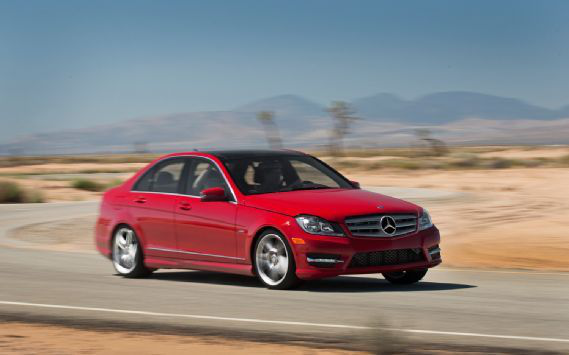

Mercedes-Benz C-Class Sedan 2012 confidence:  14.47331714630127


In [22]:
# get the class name of the prediction
display(Image.open(DATA_DIRECTORY+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())

In [24]:
# test the model on random images


# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open("../../dataset/direct/cars_test/00007.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

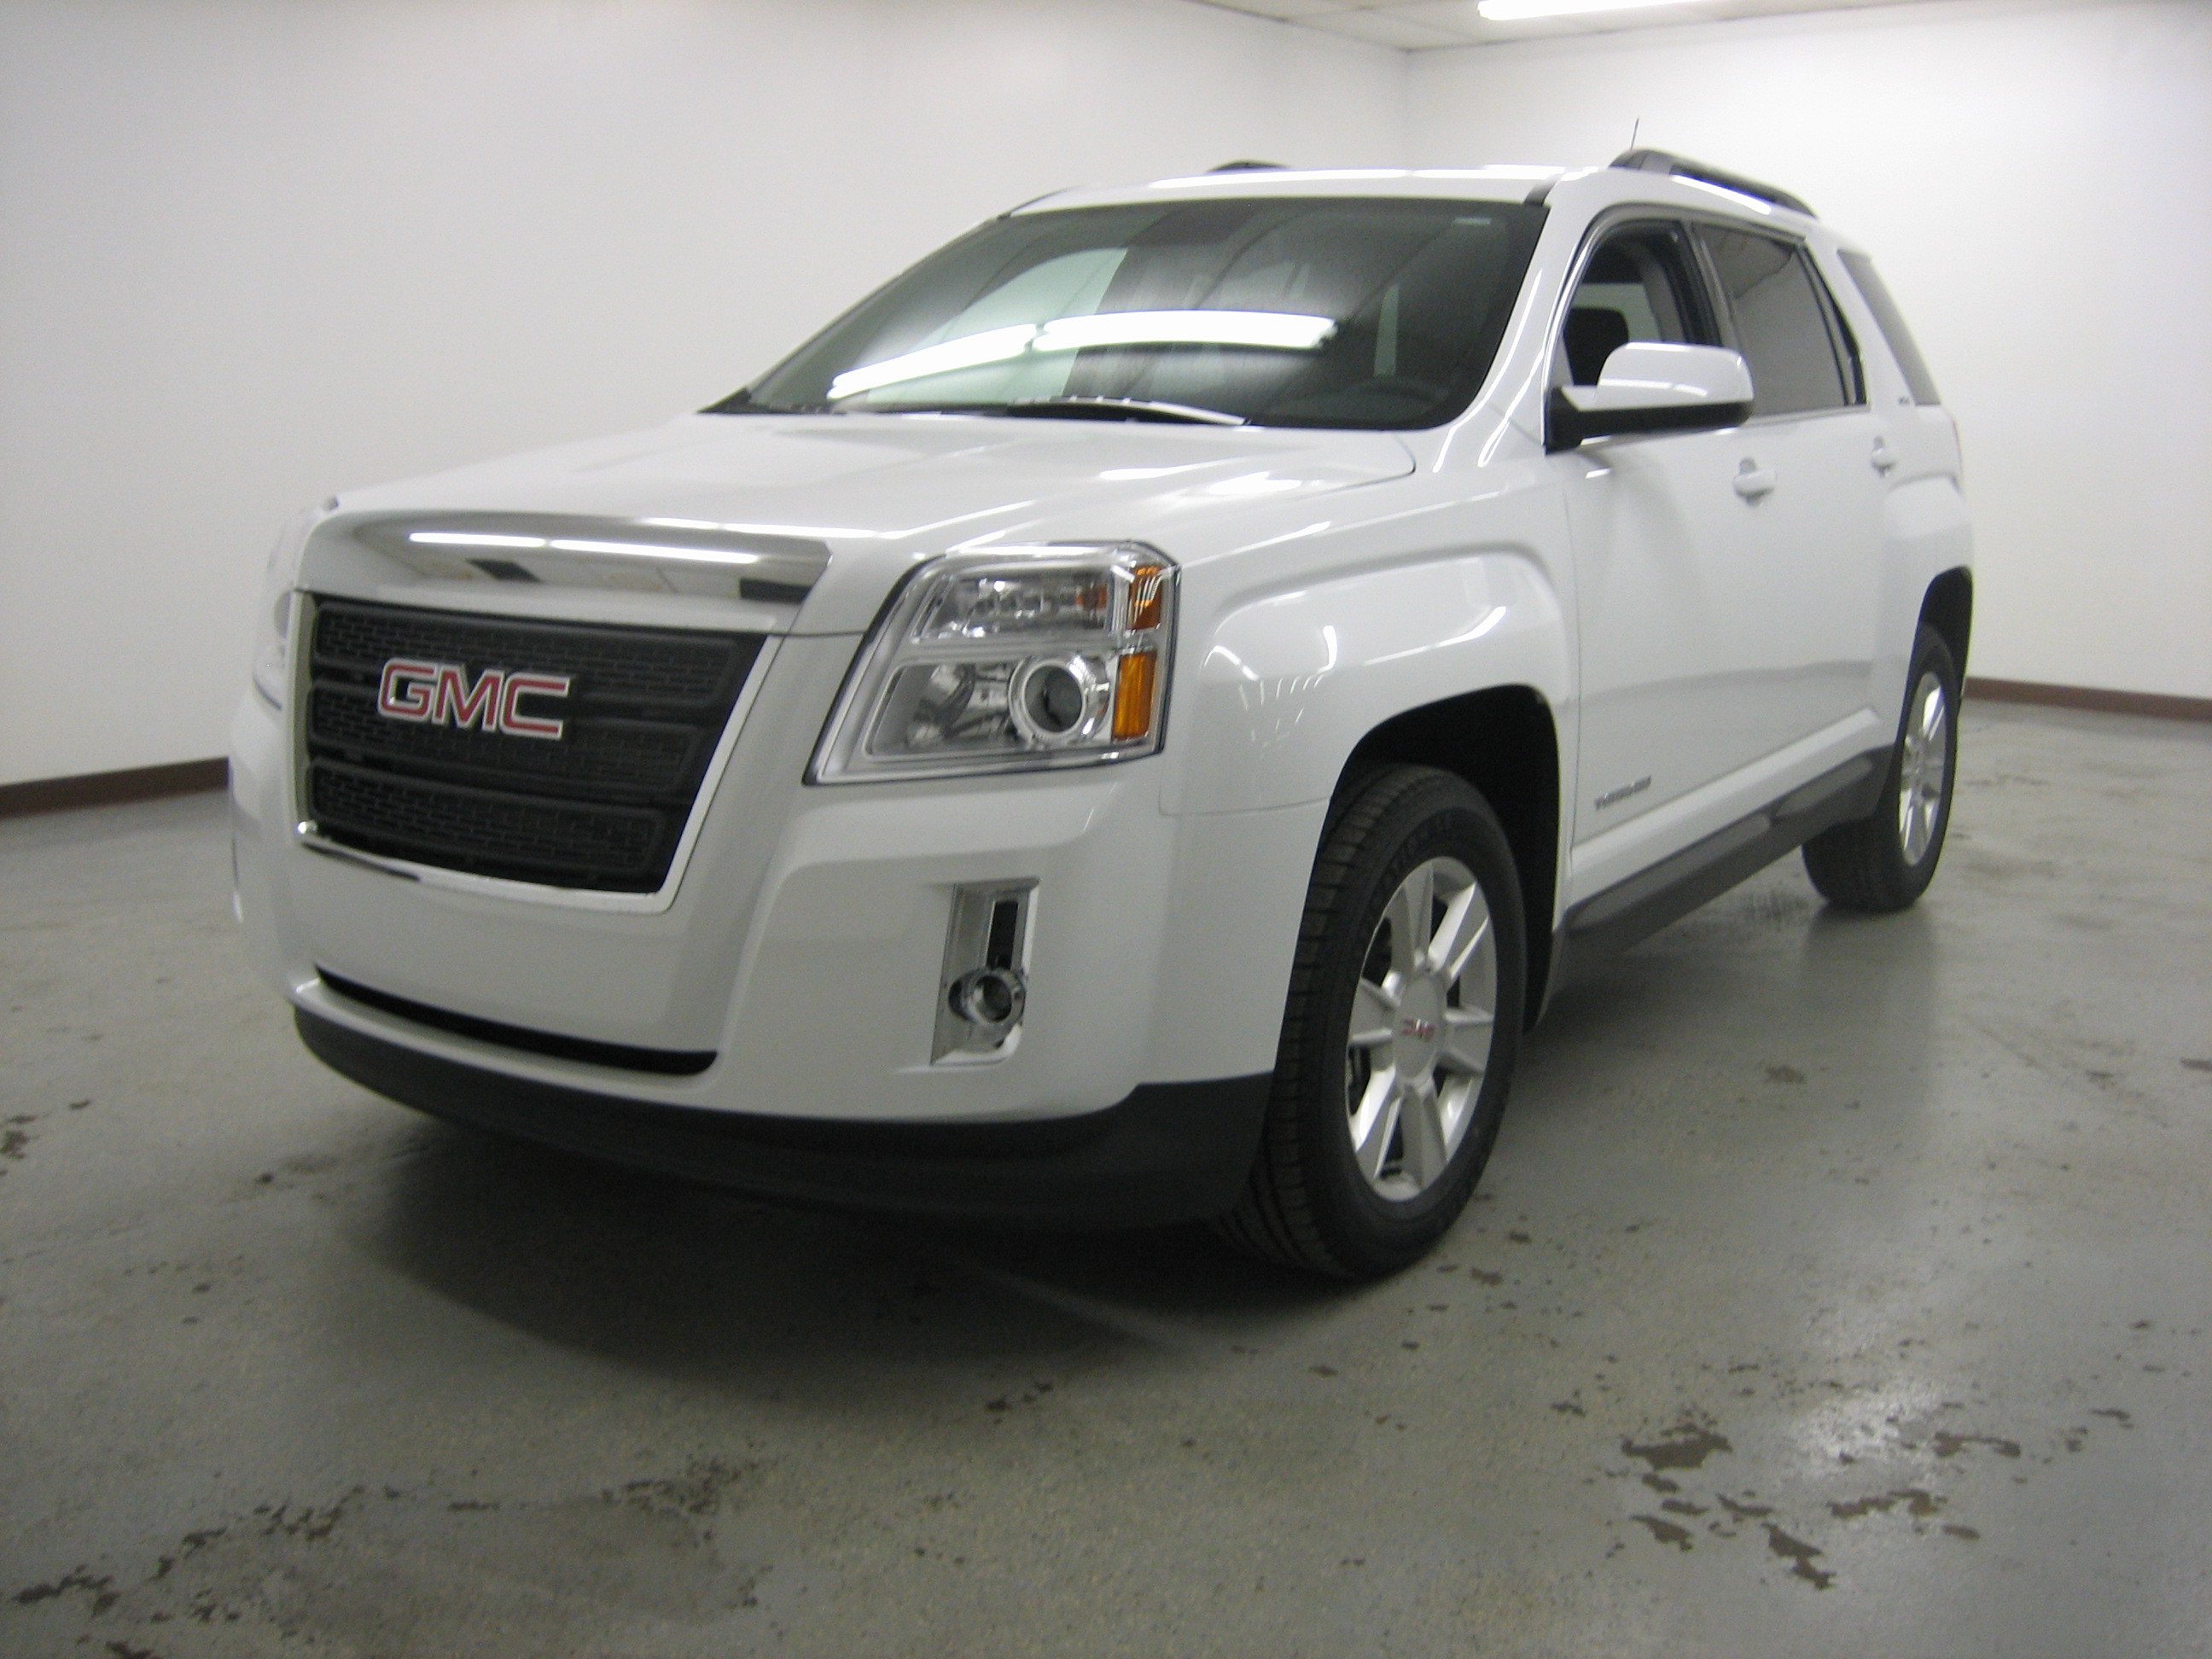

GMC Terrain SUV 2012 confidence:  17.179641723632812


In [25]:
display(Image.open("../../dataset/direct/cars_test/00007.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())